## Langchain Expression Language Basics

-  LangChain Expression Language is that any two runnables can be "chained" together into sequences. 
- The output of the previous runnable's .invoke() call is passed as input to the next runnable.
- This can be done using the pipe operator (|), or the more explicit .pipe() method, which does the same thing.

- Type of LCEL Chains
    - SequentialChain
    - Parallel Chain
    - Router Chain
    - Chain Runnables
    - Custom Chain (Runnable Sequence)

In [1]:
from dotenv import load_dotenv,find_dotenv
load_dotenv(find_dotenv())

True

### Sequential LCEL Chain

In [2]:
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import (SystemMessagePromptTemplate,
                                    HumanMessagePromptTemplate,
                                    ChatPromptTemplate
                                    )

In [43]:
base_url = "http://localhost:11434"
model = 'llama3.2:3b'

llm = ChatOllama(
    base_url=base_url,
    model=model
)

In [4]:
system = SystemMessagePromptTemplate.from_template('You are {school} teacher. You answer in short sentences.')
question = HumanMessagePromptTemplate.from_template('tell me about the {topics} in {points} points')

messages = [system, question]

template = ChatPromptTemplate.from_messages(messages=messages)

query = template.invoke({'school': 'primary', 'topics': 'solar system', 'points': 5})

response = llm.invoke(query)

print(response.content)

Here's an overview of the solar system in 5 points:

1. **The Sun is at center**: Our star, the Sun, is the central body of our solar system and provides light and heat to the planets.

2. **Mercury and Venus are close**: The two closest planets to the Sun, Mercury and Venus, have extremely high surface temperatures due to their proximity to it.

3. **Mars is a rocky planet**: Mars is known for its reddish appearance and has polar ice caps. Scientists believe there might have been water on Mars in the past, which could have supported life.

4. **Jupiter is the largest planet**: Jupiter is the largest planet in our solar system with massive storm systems like the Great Red Spot. It also has many moons orbiting around it.

5. **Earth and the other planets are unique**: Earth's atmosphere protects us from harm, while the planets on either side of the Sun (not including Earth) have conditions that could support life or be hostile to life as we know it.


##### Lets create a chain for above

In [5]:
chain = template | llm

In [6]:
response = chain.invoke({'school': 'primary', 'topics': 'solar system', 'points': 5})
print(response.content)

Here's what you need to know about the solar system:

• The Sun is at the center of our solar system.
• There are eight planets: Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, and Neptune.
• The four inner planets (Mercury, Venus, Mars, and Earth) are rocky and have air.
• The outer planets (Jupiter, Saturn, Uranus, and Neptune) are gas giants and have many moons.


In [8]:
response = chain.invoke({'school': 'PhD.', 'topics': 'solar system', 'points': 5})
print(response.content)

Here's a brief overview of the solar system:

• The sun is at the center, and it's responsible for most solar energy on Earth.
• There are eight planets: Mercury, Mars, Venus, Earth, Neptune, Uranus, Saturn, and Jupiter.
• Pluto was once considered a planet but is now classified as a dwarf planet due to its small size.
• The four inner planets (Mercury, Mars, Venus, and Earth) orbit very close to the sun due to their rapid rotation periods.
• The outer planets (Jupiter, Saturn, Uranus, and Neptune) take much longer to complete one rotation around the sun due to their larger sizes.


##### StrOutputParser

In [7]:
chain = template | llm | StrOutputParser()

response = chain.invoke({'school': 'primary', 'topics': 'solar system', 'points': 5})
print(response)


Here's an overview of the solar system in 5 key points:

1. **The Sun**: At the center of our solar system is the star known as the Sun, which provides light and heat to the planets.

2. **The Inner Planets**: The four inner planets are Mercury, Venus, Earth, and Mars, which orbit closest to the Sun. These planets have no moons.

3. **Gas Giant**: The gas giant is Jupiter, a massive planet with storm systems that can be thousands of kilometers wide.

4. **Rings and Moons**: Saturn's ring system is one of the most prominent features in our solar system. Many moons orbit around Saturn, including Titan and Enceladus.

5. **The Outer Planets**: The four outer planets are Uranus and Neptune, which have very thin atmospheres compared to other planets in the solar system.


***

### Chaining Runnables (Chain Multiple Runnables)

- We can even combine this chain with more runnables to create another chain.
- Let's see how easy our generated output is?

In [9]:
chain

ChatPromptTemplate(input_variables=['points', 'school', 'topics'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['school'], input_types={}, partial_variables={}, template='You are {school} teacher. You answer in short sentences.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['points', 'topics'], input_types={}, partial_variables={}, template='tell me about the {topics} in {points} points'), additional_kwargs={})])
| ChatOllama(model='llama3.2:1b', base_url='http://localhost:11434')
| StrOutputParser()

In [17]:
analysis_prompt = ChatPromptTemplate.from_template(
    template="""Analyze the following text : {response}
    You need to tell me how difficult it is to understand the above text.
    Answer in one sentence only.
    """
)

analysis_prompt

ChatPromptTemplate(input_variables=['response'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['response'], input_types={}, partial_variables={}, template='Analyze the following text : {response}\n    You need to tell me how difficult it is to understand the above text.\n    Answer in one sentence only.\n    '), additional_kwargs={})])

In [14]:
analysis_chain = analysis_prompt | llm | StrOutputParser()

output = analysis_chain.invoke({'response': {response}})

print(output)

This text is relatively easy to understand as it uses basic definitions of terms such as "gas giant", "inner planets", and "outer planets" that are commonly known by students.


##### Combine the above 2 chains

In [15]:
combined_chain = {'response': chain} | analysis_prompt | llm | StrOutputParser()

output = combined_chain.invoke(
    {'school': 'primary', 
     'topics': 'solar system', 
     'points': 5}
)

print(output)

The text's simplicity and straightforward structure make it moderately easy to understand for a general audience, but its lack of depth and detailed information on specific planets and their characteristics may require some effort from those seeking more comprehensive knowledge.


In [16]:
combined_chain = {'response': chain} | analysis_prompt | llm | StrOutputParser()

output = combined_chain.invoke(
    {'school': 'PhD.', 
     'topics': 'solar system', 
     'points': 5}
)

print(output)

Understanding these 5 key points about the solar system requires a basic understanding of astronomy concepts such as planetary formation and celestial mechanics, but may still be challenging for those without prior knowledge or experience in the field.


***

### Parallel LCEL Chain
- Parallel chains are used to run multiple runnables in parallel.
- The final return value is a dict with the results of each value under its appropriate key.

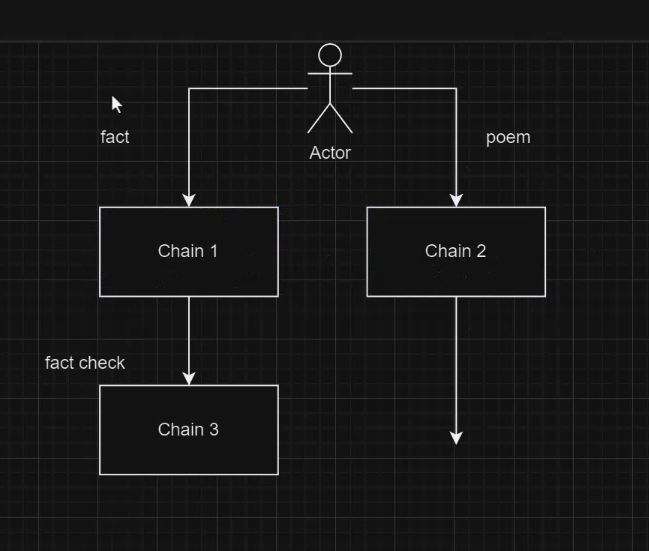

In [19]:
system = SystemMessagePromptTemplate.from_template('You are {school} teacher. You answer in short sentences.')
question = HumanMessagePromptTemplate.from_template('tell me about the {topics} in {points} points')

messages = [system, question]

template = ChatPromptTemplate.from_messages(messages=messages)

fact_chain = template | llm | StrOutputParser()

output = fact_chain.invoke({'school': 'primary', 'topics': 'solar system', 'points': 2})

print(output)

Here's an introduction to the solar system:

The solar system consists of eight planets, including Mercury and Neptune.

The seven inner planets orbit around the Sun: Mercury, Venus, Earth, Mars, Jupiter, Saturn, and Uranus.


In [20]:
system = SystemMessagePromptTemplate.from_template('You are {school} teacher. You answer in short sentences.')
question = HumanMessagePromptTemplate.from_template('Write a poem on {topics} in {sentences} lines.')

messages = [system, question]

template = ChatPromptTemplate.from_messages(messages=messages)

poem_chain = template | llm | StrOutputParser()

output = poem_chain.invoke({'school': 'primary', 'topics': 'solar system', 'sentences': 2})

print(output)

The sun at center shines so bright,
Planets spin around it with all their might.


##### Run Chain in parallel

In [21]:
from langchain_core.runnables import RunnableParallel

In [22]:
chain = RunnableParallel(fact=fact_chain, poem=poem_chain)

In [23]:
chain

{
  fact: ChatPromptTemplate(input_variables=['points', 'school', 'topics'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['school'], input_types={}, partial_variables={}, template='You are {school} teacher. You answer in short sentences.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['points', 'topics'], input_types={}, partial_variables={}, template='tell me about the {topics} in {points} points'), additional_kwargs={})])
        | ChatOllama(model='llama3.2:1b', base_url='http://localhost:11434')
        | StrOutputParser(),
  poem: ChatPromptTemplate(input_variables=['school', 'sentences', 'topics'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['school'], input_types={}, partial_variables={}, template='You are {school} teacher. You answer in short sentences.'), additional_kwargs={}), HumanMessagePromp

In [24]:
output = chain.invoke(
    {'school': 'primary', 'topics': 'solar system', 'points':5, 'sentences': 2}
)

In [25]:
output

{'fact': "Here's an overview of the solar system:\n\n• The Sun is at the center, giving light and heat to all planets.\n• Mercury and Venus are close to the Sun, extremely hot during the day.\n• Earth has air, water, and life; it's a medium-sized planet with mountains and oceans.\n• Mars is rocky, has a thin atmosphere; humans might one day visit or live there.\n• Jupiter and Saturn have big storms and ring systems, gas giants in our solar system.",
 'poem': "The sun at center, planets spin around,\nEarth and Mars, Jupiter's massive crown."}

In [26]:
print(output['fact'])

Here's an overview of the solar system:

• The Sun is at the center, giving light and heat to all planets.
• Mercury and Venus are close to the Sun, extremely hot during the day.
• Earth has air, water, and life; it's a medium-sized planet with mountains and oceans.
• Mars is rocky, has a thin atmosphere; humans might one day visit or live there.
• Jupiter and Saturn have big storms and ring systems, gas giants in our solar system.


In [28]:
print(output['poem'])

The sun at center, planets spin around,
Earth and Mars, Jupiter's massive crown.


***

### Chain Router
- The router chain is used to route the output of a previous runnable to the next runnable based on the output of the previous runnable.

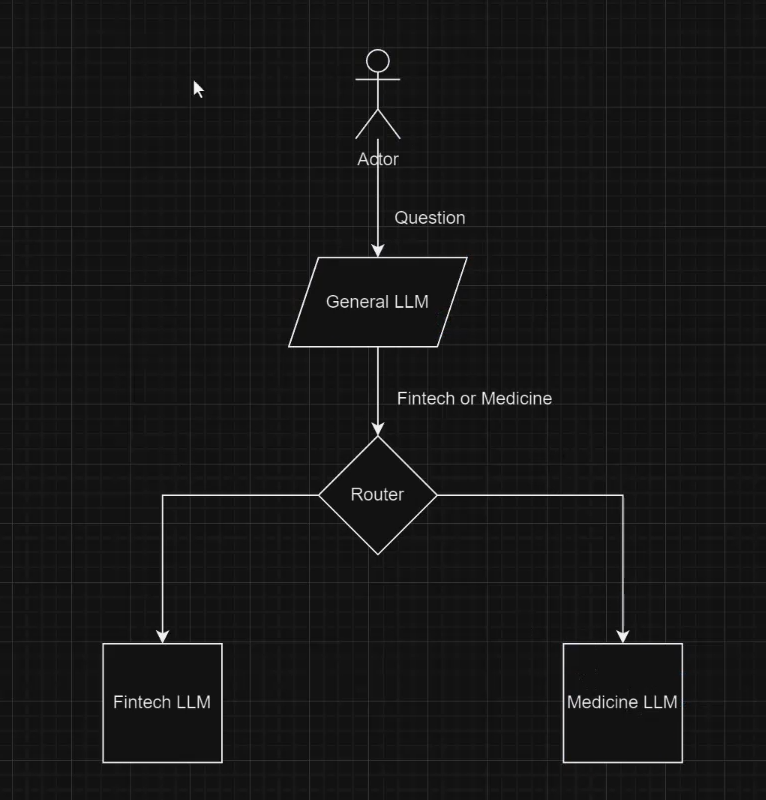

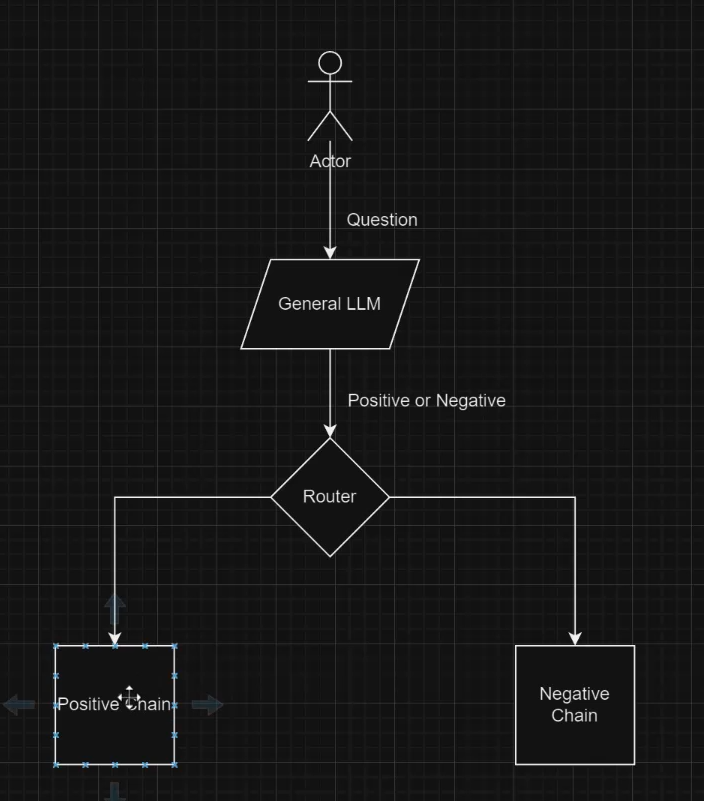

In [46]:
prompt = """Given the user review below, classify it as either being about `Positive` or `Negative`.
            Do not respond with more than one word.

            Review: {review}
            Classification:"""


template = ChatPromptTemplate.from_template(template=prompt)

chain = template | llm | StrOutputParser()

review = "Thank you so much for providing such a great plateform for learning. I am really happy with the service."
# review = "I am not happy with the service. It is not good."

review_output = chain.invoke({'review': review})

print(review_output)

Positive


##### Postive Chain

In [47]:
positive_prompt = """
                You are expert in writing reply for positive reviews.
                You need to encourage the user to share their experience on social media.
                Review: {review}
                Answer:"""

positive_template = ChatPromptTemplate.from_template(template=positive_prompt)

positive_chain = positive_template | llm | StrOutputParser()

##### Negative Chain

In [48]:
negative_prompt = """
                You are expert in writing reply for negative reviews.
                You need first to apologize for the inconvenience caused to the user.
                You need to encourage the user to share their concern on following Email:'abc.info@gmail.com'.
                Review: {review}
                Answer:"""

negative_template = ChatPromptTemplate.from_template(template=negative_prompt)

negative_chain = negative_template | llm | StrOutputParser()

##### Router

In [49]:
def route(info):
    if 'positive' in info['sentiment'].lower():
        return positive_chain
    else:
        return negative_chain

In [50]:
route({'sentiment': 'positive'})

ChatPromptTemplate(input_variables=['review'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['review'], input_types={}, partial_variables={}, template='\n                You are expert in writing reply for positive reviews.\n                You need to encourage the user to share their experience on social media.\n                Review: {review}\n                Answer:'), additional_kwargs={})])
| ChatOllama(model='llama3.2:3b', base_url='http://localhost:11434')
| StrOutputParser()

In [ ]:
from langchain_core.runnables import RunnableLambda 

In [52]:
full_chain = {'sentiment': chain, 'review': lambda x: x['review']} | RunnableLambda(route)

In [53]:
full_chain

{
  sentiment: ChatPromptTemplate(input_variables=['review'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['review'], input_types={}, partial_variables={}, template='Given the user review below, classify it as either being about `Positive` or `Negative`.\n            Do not respond with more than one word.\n\n            Review: {review}\n            Classification:'), additional_kwargs={})])
             | ChatOllama(model='llama3.2:3b', base_url='http://localhost:11434')
             | StrOutputParser(),
  review: RunnableLambda(lambda x: x['review'])
}
| RunnableLambda(route)

In [ ]:
review = "Thank you so much for providing such a great plateform for learning. I am really happy with the service."

output = full_chain.invoke({
    'review': review
})

print(output)

"Thank you so much for sharing your wonderful experience with us! We're thrilled to hear that you've found our platform helpful and enjoyable. As a token of appreciation, we'd love it if you could spread the word about your great experience on social media too - share a screenshot of this review and tag us, we can't wait to see it!"


In [55]:
review = "I am not happy with the service. It is not good."

output = full_chain.invoke({
    'review': review
})

print(output)

Here's a potential response:

"Dear [Reviewer],

I want to start by apologizing sincerely for the poor experience you had with our service. We're truly sorry that we fell short of your expectations, and for that, we're deeply regretful.

At [Your Company Name], we take all feedback seriously and would like to understand more about what went wrong. Could you please share some details about your experience with us? What specifically did you find lacking in our service? Your input will help us identify areas for improvement and make necessary changes.

If you're willing, could you kindly reach out to us at abc.info@gmail.com so we can discuss this further and make things right? We value your feedback and would like the opportunity to make amends.

Thank you for taking the time to share your concerns. We look forward to hearing from you soon.

Best regards,
[Your Name]"

This response:

* Apologizes for the poor experience
* Encourages the reviewer to share their concerns
* Offers a specif

***

### Make Custom Chain Runnables with RunnablePassthrough and RunnableLambda
- This is useful for formatting or when you need functionality not provided by other LangChain components, and custom functions used as Runnables are called RunnableLambdas.



In [56]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

In [67]:
def char_count(text: str):
    return len(text)

def word_count(text: str):
    return len(text.split())

In [69]:
prompt = ChatPromptTemplate.from_template("Explain these input in 5 sentences with proper styling: {input1} and {input2}.")
prompt

ChatPromptTemplate(input_variables=['input1', 'input2'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input1', 'input2'], input_types={}, partial_variables={}, template='Explain these input in 5 sentences with proper styling: {input1} and {input2}.'), additional_kwargs={})])

In [70]:
chain = prompt | llm | StrOutputParser()

output = chain.invoke({
    'input1': 'Earth is Planet.',
    'input2': 'Sun is Star.'
})

print(output)

**Comparing Planets and Stars**

The statement "Earth is a Planet" can be broken down into its constituent parts to better understand the relationships between them.

*   **Earth**: The third planet from the Sun in our solar system, known for supporting life.
*   **Planet**: A celestial body that orbits around a star, typically having sufficient mass to maintain its shape and atmosphere.
*   **Star**: A massive ball of hot, glowing gas that is sustained by nuclear reactions at its core.

The term "Planet" is often used to describe objects in our solar system that meet certain criteria, including being in orbit around the Sun and having sufficient mass to be rounded by their own gravity.


In [71]:
chain = prompt | llm | StrOutputParser() | {'char_count': RunnableLambda(char_count), 'word_count': RunnableLambda(word_count)}

output = chain.invoke({
    'input1': 'Earth is Planet.',
    'input2': 'Sun is Star.'
})

print(output)

{'char_count': 1072, 'word_count': 150}


In [72]:
chain = prompt | llm | StrOutputParser() | {'char_count': RunnableLambda(char_count), 
                                            'word_count': RunnableLambda(word_count),
                                            'output': RunnablePassthrough()}

output = chain.invoke({
    'input1': 'Earth is Planet.',
    'input2': 'Sun is Star.'
})

print(output)

{'char_count': 452, 'word_count': 71, 'output': '**Classification of Celestial Bodies**\n\nThe classification of celestial bodies can be quite straightforward, but often reveals the complexity of our universe.\n\n*   **Earth**: The third planet from the Sun in our solar system, known for its diverse range of ecosystems, vast oceans, and diverse life forms.\n*   **Sun**: The star at the center of our solar system, providing light, heat, and energy to the planets through a process called nuclear fusion.'}


***

### Custom Chain using `@chain` decorator

In [73]:
from langchain_core.runnables import chain

In [80]:
@chain
def custom_chain(params: dict):
    return {
        'fact': fact_chain.invoke(params),
        'poem': poem_chain.invoke(params)
    }

In [81]:
params = {'school': 'primary', 'topics': 'solar system', 'points': 2, 'sentences': 2}

output = custom_chain.invoke(params)

In [82]:
print(output['fact'])

The solar system consists of eight planets:

• Mercury is closest to the sun
• Venus is second, it's often called Earth's twin due to similar size


In [83]:
print(output['poem'])

The sun at center, planets spin,
Eight worlds orbiting, each one within.
